In [1]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from lifelines import KaplanMeierFitter
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import gaussian_kde
from scipy.optimize import minimize
import time
from lifelines import KaplanMeierFitter
import pickle

In [2]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from lifelines import KaplanMeierFitter
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import gaussian_kde
from scipy.optimize import minimize
import time
from scipy.stats import gamma, norm, expon
from scipy.optimize import minimize
import time      

# Fitting

In [28]:
def fit_arrival(df):
    df = df.sort_values(['Arrival Time'])
    df['Interarrival Time'] = df['Arrival Time'].diff()
    df['Interarrival Time'] = np.where(df['Interarrival Time']>0, df['Interarrival Time'], 0.1)
    arrivals_tmp = df["Interarrival Time"]
    arrival_param = expon.fit(arrivals_tmp)
    arrival_param =  arrival_param[1]
    return arrival_param

In [29]:
with open('params.pkl', 'rb') as f:
    params_all = pickle.load(f)

In [30]:
num_contact_groups = 2
num_days = 5 
macro_rep = 1
num_days_consider = 1 # This is what is going to be used. num_days is the max number of 
num_contact_groups = 2
rho_1, rho_2 = params_all[1]['rho'], params_all[2]['rho']
# _________
hours_of_operation = 9
hours_of_termination = 13
arrival_params_dict = {1:[], 2:[]}
for i in range(1, macro_rep+1):
    n_replications = num_days
    minutes_stat_col = 30
    minutes_shift_ch = 30
    df_train = pd.DataFrame()
    for j in range(1, num_days_consider+1):
        df_train_tmp = pd.read_csv(f'data_censored/Simulated_Contact_Macro_{i}_Day_{j}_Params_{rho_1}_{rho_2}.csv')
        df_train = pd.concat([df_train, df_train_tmp])
    for contact_group in range(1, num_contact_groups+1):
        df_train_contact = df_train[df_train['Contact Group']==contact_group]
        arrival_params_tmp = fit_arrival(df_train_contact)
        arrival_params_dict[contact_group].append(arrival_params_tmp)




# Generating

In [31]:
def generate_arrivals_until(T_max=540, scale=1.0):
    arrivals = []
    t = 0.0
    while t < T_max:
        t += np.random.exponential(scale=scale)
        if t <= T_max:
            arrivals.append(t)
    return np.array(arrivals)

In [32]:
macro_rep = macro_rep # so that you knwo they should be the same.
num_reps = 500
for i in range(1, macro_rep+1):
    for j in range(1, num_reps+1):
        for contact_group in range(1, num_contact_groups+1):
            A = generate_arrivals_until(540, scale=arrival_params_dict[contact_group][i-1])
            df_tmp = pd.DataFrame({
                'Contact Group':contact_group,
                'Arrival Time':  A})
            df_tmp.to_csv(f'data_sim_arrival/Contact_Sim_Group_{contact_group}_Macro_{i}_Rep_{j}_Params_{rho_1}_{rho_2}.csv')

In [33]:
with open("data.txt", "r") as f:
    my_list = eval(f.read())   # be careful with eval!

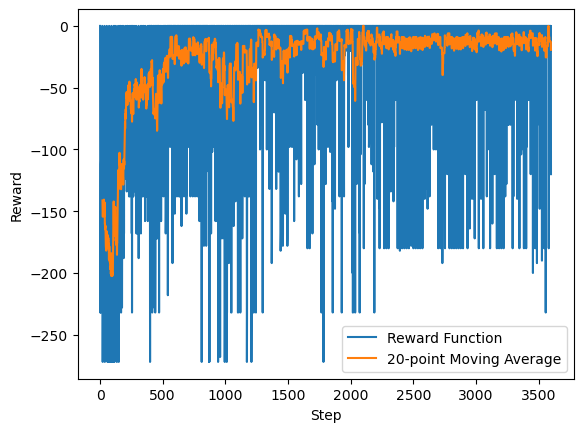

In [41]:
arr = np.array(my_list)

k = 20
moving_avg = np.convolve(arr, np.ones(k)/k, mode='valid')

plt.plot(arr, label="Reward Function")
plt.plot(range(k-1, len(arr)), moving_avg, label=f"{k}-point Moving Average")
# plt.xlim(1000, 1500)
plt.legend()
plt.xlabel("Step")
plt.ylabel("Reward")
plt.savefig(f'reward_function.png')
plt.show()

In [35]:
my_list

[0,
 -152,
 -232,
 -178,
 -232,
 -172,
 -168,
 -112,
 -108,
 -158,
 -142,
 -158,
 -122,
 -108,
 -98,
 -178,
 -168,
 -108,
 0,
 -232,
 -142,
 -272,
 -232,
 -172,
 -82,
 -132,
 -108,
 -118,
 -192,
 -98,
 -112,
 -138,
 -232,
 -232,
 -138,
 -118,
 0,
 -182,
 -272,
 -232,
 -232,
 -232,
 -232,
 -152,
 -232,
 -208,
 -212,
 -152,
 -232,
 -98,
 -98,
 -98,
 -152,
 -192,
 0,
 -158,
 -182,
 -232,
 -142,
 -272,
 -152,
 -192,
 -232,
 -232,
 -232,
 -232,
 -152,
 -272,
 -232,
 -62,
 -232,
 -232,
 0,
 -128,
 -4,
 -232,
 -232,
 -272,
 -232,
 -232,
 -232,
 -222,
 -272,
 -192,
 -272,
 -232,
 -232,
 -232,
 -232,
 -132,
 0,
 -98,
 -222,
 -272,
 -4,
 -232,
 -232,
 -232,
 -272,
 -192,
 -232,
 -232,
 -232,
 -4,
 -4,
 -4,
 -14,
 -232,
 0,
 -138,
 -232,
 -232,
 -272,
 -142,
 -272,
 -34,
 -232,
 0,
 -232,
 -232,
 -232,
 -192,
 -232,
 -232,
 -94,
 -232,
 0,
 -212,
 -98,
 -94,
 -232,
 -192,
 -232,
 -272,
 -272,
 -192,
 -34,
 -4,
 -94,
 -38,
 -4,
 -94,
 -148,
 0,
 0,
 -138,
 -20,
 -172,
 -232,
 -272,
 -144,
 -138,
 

In [36]:
# Train 

In [5]:
class Simulation_Surrogate:
    def __init__(self):
        self.dataset = pd.DataFrame({'State In':[], 'Action':[], 'KPI':[], 'State Out':[]})
        self.dataset = self.dataset.astype({
            "State In": object,
            "Action": object,
            "KPI": object,
            "State Out": object
        })

        self.model = None
    def train_surrogate(self):
        pass


In [13]:
import pickle

with open("sim_surrogate.pkl", "rb") as f:
    sim_surrogate = pickle.load(f)

In [14]:
sim_surrogate.dataset['KPI']

0      [[0.45092040000000005, 0.01], [0.0, 0.0], [0.5...
1      [[0.505, 1.136646], [0.0, 0.0], [0.23967470000...
2      [[0.505, 0.01], [0.0, 0.0], [0.180293066666666...
3      [[0.6394833999999999, 0.3066666666666667], [0....
4      [[0.01, 0.3066666666666667], [0.0, 0.0], [0.26...
                             ...                        
895    [[3.155174375, 8.81494825], [1.0, 1.0], [1.0, ...
896    [[0.01, 0.01], [0.0, 0.0], [0.1428869000000001...
897    [[1.2413323333333335, 0.2325], [0.0, 0.0], [0....
898    [[0.01, 0.01], [0.0, 0.0], [0.3431210333333335...
899    [[1.4615095, 0.01], [0.3333333333333333, 0.0],...
Name: KPI, Length: 900, dtype: object

In [15]:
len(sim_surrogate.dataset)

900

In [16]:
sim_surrogate.dataset["Input"] = sim_surrogate.dataset.apply(
    lambda row: row["State In"] + row["Action"], axis=1
)
sim_surrogate.dataset

,State In,Action,KPI,State Out,Input
0,"[0, 0, 2, 2, 3, 2, 0, 5, 6]","[0, 0, 0, 0]","[[0.45092040000000005, 0.01], [0.0, 0.0], [0.5...","[0, 0, 2, 2, 3, 2, 1]","[0, 0, 2, 2, 3, 2, 0, 5, 6, 0, 0, 0, 0]"
1,"[0, 0, 2, 2, 3, 2, 1, 4, 5]","[0, 0, 0, 0]","[[0.505, 1.136646], [0.0, 0.0], [0.23967470000...","[0, 0, 2, 2, 3, 2, 2]","[0, 0, 2, 2, 3, 2, 1, 4, 5, 0, 0, 0, 0]"
2,"[0, 0, 2, 2, 3, 2, 2, 3, 3]","[0, 0, 0, 0]","[[0.505, 0.01], [0.0, 0.0], [0.180293066666666...","[0, 0, 2, 2, 3, 2, 3]","[0, 0, 2, 2, 3, 2, 2, 3, 3, 0, 0, 0, 0]"
3,"[0, 0, 2, 2, 3, 2, 3, 6, 5]","[0, 0, 0, 0]","[[0.6394833999999999, 0.3066666666666667], [0....","[0, 0, 2, 2, 3, 2, 4]","[0, 0, 2, 2, 3, 2, 3, 6, 5, 0, 0, 0, 0]"
4,"[0, 0, 2, 2, 3, 2, 4, 3, 4]","[0, 0, 0, 0]","[[0.01, 0.3066666666666667], [0.0, 0.0], [0.26...","[0, 0, 2, 2, 3, 2, 5]","[0, 0, 2, 2, 3, 2, 4, 3, 4, 0, 0, 0, 0]"
...,...,...,...,...,...
895,"[0, 0, 0, 2, 3, 2, 13, 8, 4]","[5, 5, 5, 5]","[[3.155174375, 8.81494825], [1.0, 1.0], [1.0, ...","[0, 0, 0, 1, 0, 0, 14]","[0, 0, 0, 2, 3, 2, 13, 8, 4, 5, 5, 5, 5]"
896,"[0, 0, 0, 1, 0, 0, 14, 2, 7]","[0, 0, 0, 0]","[[0.01, 0.01], [0.0, 0.0], [0.1428869000000001...","[0, 1, 0, 1, 0, 0, 15]","[0, 0, 0, 1, 0, 0, 14, 2, 7, 0, 0, 0, 0]"
897,"[0, 1, 0, 1, 0, 0, 15, 6, 4]","[0, 0, 0, 0]","[[1.2413323333333335, 0.2325], [0.0, 0.0], [0....","[0, 0, 0, 1, 0, 0, 16]","[0, 1, 0, 1, 0, 0, 15, 6, 4, 0, 0, 0, 0]"
898,"[0, 0, 0, 1, 0, 0, 16, 4, 5]","[0, 0, 0, 0]","[[0.01, 0.01], [0.0, 0.0], [0.3431210333333335...","[0, 0, 0, 1, 0, 0, 17]","[0, 0, 0, 1, 0, 0, 16, 4, 5, 0, 0, 0, 0]"


In [17]:
sim_surrogate.dataset["KPI_flat_init"] = sim_surrogate.dataset["KPI"].apply(
    lambda kpi: [item for sub in kpi for item in sub]
)
sim_surrogate.dataset

sim_surrogate.dataset["KPI_flat"] = sim_surrogate.dataset.apply(
    lambda row: row["KPI_flat_init"] + row["State Out"], axis=1
)
sim_surrogate.dataset

,State In,Action,KPI,State Out,Input,KPI_flat_init,KPI_flat
0,"[0, 0, 2, 2, 3, 2, 0, 5, 6]","[0, 0, 0, 0]","[[0.45092040000000005, 0.01], [0.0, 0.0], [0.5...","[0, 0, 2, 2, 3, 2, 1]","[0, 0, 2, 2, 3, 2, 0, 5, 6, 0, 0, 0, 0]","[0.45092040000000005, 0.01, 0.0, 0.0, 0.597294...","[0.45092040000000005, 0.01, 0.0, 0.0, 0.597294..."
1,"[0, 0, 2, 2, 3, 2, 1, 4, 5]","[0, 0, 0, 0]","[[0.505, 1.136646], [0.0, 0.0], [0.23967470000...","[0, 0, 2, 2, 3, 2, 2]","[0, 0, 2, 2, 3, 2, 1, 4, 5, 0, 0, 0, 0]","[0.505, 1.136646, 0.0, 0.0, 0.2396747000000000...","[0.505, 1.136646, 0.0, 0.0, 0.2396747000000000..."
2,"[0, 0, 2, 2, 3, 2, 2, 3, 3]","[0, 0, 0, 0]","[[0.505, 0.01], [0.0, 0.0], [0.180293066666666...","[0, 0, 2, 2, 3, 2, 3]","[0, 0, 2, 2, 3, 2, 2, 3, 3, 0, 0, 0, 0]","[0.505, 0.01, 0.0, 0.0, 0.18029306666666683, 0...","[0.505, 0.01, 0.0, 0.0, 0.18029306666666683, 0..."
3,"[0, 0, 2, 2, 3, 2, 3, 6, 5]","[0, 0, 0, 0]","[[0.6394833999999999, 0.3066666666666667], [0....","[0, 0, 2, 2, 3, 2, 4]","[0, 0, 2, 2, 3, 2, 3, 6, 5, 0, 0, 0, 0]","[0.6394833999999999, 0.3066666666666667, 0.0, ...","[0.6394833999999999, 0.3066666666666667, 0.0, ..."
4,"[0, 0, 2, 2, 3, 2, 4, 3, 4]","[0, 0, 0, 0]","[[0.01, 0.3066666666666667], [0.0, 0.0], [0.26...","[0, 0, 2, 2, 3, 2, 5]","[0, 0, 2, 2, 3, 2, 4, 3, 4, 0, 0, 0, 0]","[0.01, 0.3066666666666667, 0.0, 0.0, 0.2667799...","[0.01, 0.3066666666666667, 0.0, 0.0, 0.2667799..."
...,...,...,...,...,...,...,...
895,"[0, 0, 0, 2, 3, 2, 13, 8, 4]","[5, 5, 5, 5]","[[3.155174375, 8.81494825], [1.0, 1.0], [1.0, ...","[0, 0, 0, 1, 0, 0, 14]","[0, 0, 0, 2, 3, 2, 13, 8, 4, 5, 5, 5, 5]","[3.155174375, 8.81494825, 1.0, 1.0, 1.0, 1.0, ...","[3.155174375, 8.81494825, 1.0, 1.0, 1.0, 1.0, ..."
896,"[0, 0, 0, 1, 0, 0, 14, 2, 7]","[0, 0, 0, 0]","[[0.01, 0.01], [0.0, 0.0], [0.1428869000000001...","[0, 1, 0, 1, 0, 0, 15]","[0, 0, 0, 1, 0, 0, 14, 2, 7, 0, 0, 0, 0]","[0.01, 0.01, 0.0, 0.0, 0.14288690000000012, 0....","[0.01, 0.01, 0.0, 0.0, 0.14288690000000012, 0...."
897,"[0, 1, 0, 1, 0, 0, 15, 6, 4]","[0, 0, 0, 0]","[[1.2413323333333335, 0.2325], [0.0, 0.0], [0....","[0, 0, 0, 1, 0, 0, 16]","[0, 1, 0, 1, 0, 0, 15, 6, 4, 0, 0, 0, 0]","[1.2413323333333335, 0.2325, 0.0, 0.0, 0.53771...","[1.2413323333333335, 0.2325, 0.0, 0.0, 0.53771..."
898,"[0, 0, 0, 1, 0, 0, 16, 4, 5]","[0, 0, 0, 0]","[[0.01, 0.01], [0.0, 0.0], [0.3431210333333335...","[0, 0, 0, 1, 0, 0, 17]","[0, 0, 0, 1, 0, 0, 16, 4, 5, 0, 0, 0, 0]","[0.01, 0.01, 0.0, 0.0, 0.3431210333333335, 0.3...","[0.01, 0.01, 0.0, 0.0, 0.3431210333333335, 0.3..."


In [18]:
sim_surrogate.dataset = sim_surrogate.dataset[
    sim_surrogate.dataset["KPI_flat"].apply(lambda x: len(x) != 16)
].reset_index(drop=True)

In [19]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

df = sim_surrogate.dataset   # or whatever your df is called


X = np.stack(df["Input"].to_list()).astype(np.float32)     
Y = np.stack(df["KPI_flat"].to_list()).astype(np.float32)   

N, input_dim = X.shape
output_dim = Y.shape[1]
print(f"Input dim: {input_dim}, Output dim: {output_dim}, N: {N}")


X_tensor = torch.from_numpy(X)
Y_tensor = torch.from_numpy(Y)

dataset = TensorDataset(X_tensor, Y_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True)


class SurrogateNN(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, out_dim)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SurrogateNN(input_dim, output_dim).to(device)

# ----------------------------------------------------
# 4. Loss and optimizer
# ----------------------------------------------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ----------------------------------------------------
# 5. Training loop
# ----------------------------------------------------
epochs = 50

model.train()
for epoch in range(epochs):
    total_loss = 0.0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)

    avg_loss = total_loss / N
    print(f"Epoch {epoch+1}/{epochs}  Loss: {avg_loss:.6f}")

# ----------------------------------------------------
# 6. Example: using the trained model for prediction
# ----------------------------------------------------



Input dim: 13, Output dim: 18, N: 899
Epoch 1/50  Loss: 8.037293
Epoch 2/50  Loss: 6.518776
Epoch 3/50  Loss: 4.611592
Epoch 4/50  Loss: 2.624730
Epoch 5/50  Loss: 1.266295
Epoch 6/50  Loss: 0.833066
Epoch 7/50  Loss: 0.654302
Epoch 8/50  Loss: 0.492657
Epoch 9/50  Loss: 0.377615
Epoch 10/50  Loss: 0.303764
Epoch 11/50  Loss: 0.257475
Epoch 12/50  Loss: 0.230895
Epoch 13/50  Loss: 0.213746
Epoch 14/50  Loss: 0.204728
Epoch 15/50  Loss: 0.193275
Epoch 16/50  Loss: 0.187833
Epoch 17/50  Loss: 0.178575
Epoch 18/50  Loss: 0.174859
Epoch 19/50  Loss: 0.171276
Epoch 20/50  Loss: 0.166603
Epoch 21/50  Loss: 0.160533
Epoch 22/50  Loss: 0.157308
Epoch 23/50  Loss: 0.154248
Epoch 24/50  Loss: 0.150421
Epoch 25/50  Loss: 0.143816
Epoch 26/50  Loss: 0.141519
Epoch 27/50  Loss: 0.135879
Epoch 28/50  Loss: 0.130917
Epoch 29/50  Loss: 0.126959
Epoch 30/50  Loss: 0.120515
Epoch 31/50  Loss: 0.116339
Epoch 32/50  Loss: 0.111977
Epoch 33/50  Loss: 0.108512
Epoch 34/50  Loss: 0.105107
Epoch 35/50  Loss: 

In [23]:
sim_surrogate.model = model

In [24]:
with open("sim_surrogate_trained.pkl", "wb") as f:
    pickle.dump(sim_surrogate, f)

In [25]:
model.eval()
with torch.no_grad():
    # take first row as an example input
    x_example = X_tensor[0:1].to(device)    # shape (1, input_dim)
    y_pred = model(x_example).cpu().numpy()
    y_pred[0][-4:] = np.round(y_pred[0][-4:])
    print("Input example:", df["Input"].iloc[0])
    print("True KPI_flat:", df["KPI_flat"].iloc[0])
    print("Predicted KPI_flat:", y_pred[0])

Input example: [0, 0, 2, 2, 3, 2, 0, 5, 3, 0, 0, 0, 0]
True KPI_flat: [0.01, 0.01, 0.0, 0.0, 0.44265309999999997, 0.23506921666666666, 0.0, 2, 2, 3, 2, 0, 0, 2, 2, 3, 2, 1]
Predicted KPI_flat: [ 4.9428067e-01 -9.1577768e-03  4.8828177e-02  2.2308920e-03
  4.2166853e-01  3.1189042e-01  2.2603042e-01  1.9599383e+00
  1.9875911e+00  3.0229340e+00  2.0107653e+00  1.1942044e-01
 -1.0617219e-01  1.9678706e+00  2.0000000e+00  3.0000000e+00
  2.0000000e+00  1.0000000e+00]


# Test Data

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

df = sim_surrogate.dataset   # or whatever your df is called


X = np.stack(df["Input"].to_list()).astype(np.float32)     
Y = np.stack(df["KPI_flat"].to_list()).astype(np.float32)   

X_train, X_test, y_train, y_test = train_test_split(X,y, ration)



N, input_dim = X.shape
output_dim = Y.shape[1]
print(f"Input dim: {input_dim}, Output dim: {output_dim}, N: {N}")


X_tensor = torch.from_numpy(X)
Y_tensor = torch.from_numpy(Y)


dataset = TensorDataset(X_tensor, Y_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True)


class SurrogateNN(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, out_dim)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SurrogateNN(input_dim, output_dim).to(device)

# ----------------------------------------------------
# 4. Loss and optimizer
# ----------------------------------------------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ----------------------------------------------------
# 5. Training loop
# ----------------------------------------------------
epochs = 50

model.train()
for epoch in range(epochs):
    total_loss = 0.0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)

    avg_loss = total_loss / N
    print(f"Epoch {epoch+1}/{epochs}  Loss: {avg_loss:.6f}")

# ----------------------------------------------------
# 6. Example: using the trained model for prediction
# ----------------------------------------------------



# Generate True RL Arrivals

In [39]:
macro_rep = macro_rep # so that you knwo they should be the same.
num_reps = 50
for i in range(1, macro_rep+1):
    for j in range(1, num_reps+1):
        for contact_group in range(1, num_contact_groups+1):
            A = generate_arrivals_until(540, scale=arrival_params_dict[contact_group][i-1])
            df_tmp = pd.DataFrame({
                'Contact Group':contact_group,
                'Arrival Time':  A})
            df_tmp.to_csv(f'data_sim_arrival_rl/Contact_Sim_Group_{contact_group}_Macro_{i}_Rep_{j}_Params_{rho_1}_{rho_2}.csv')

# Analyze results

In [69]:
rl_dataset_rl = pd.read_csv(f'data_stat/Contact_Stat_Copula_Macro_1_Params_0.7_0.7.csv')
rl_dataset_wrl = pd.read_csv(f'data_stat/Contact_Stat_WRL_Copula_Macro_1_Params_0.7_0.7.csv')

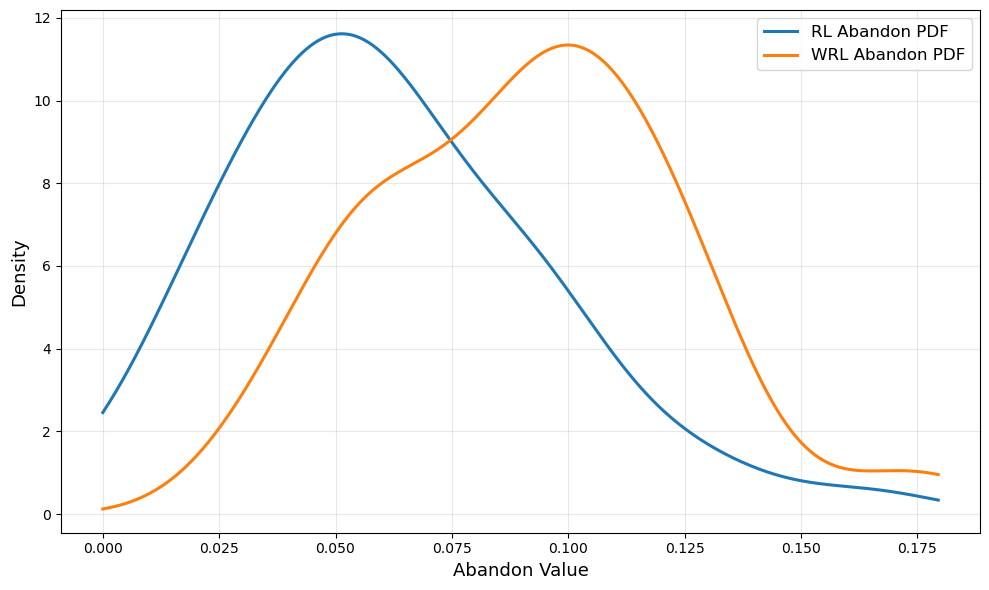

In [70]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

contact_group = 1
d1 = rl_dataset_rl[rl_dataset_rl['Contact Group'] == contact_group]['Abandon'].dropna()
d2 = rl_dataset_wrl[rl_dataset_wrl['Contact Group'] == contact_group]['Abandon'].dropna()

# KDEs
kde1 = gaussian_kde(d1)
kde2 = gaussian_kde(d2)

# Build a shared x-grid
xmin = min(d1.min(), d2.min())
xmax = max(d1.max(), d2.max())
x = np.linspace(xmin, xmax, 400)

# Plot
plt.figure(figsize=(10,6))

plt.plot(x, kde1(x), linewidth=2.2, label='RL Abandon PDF')
plt.plot(x, kde2(x), linewidth=2.2, label='WRL Abandon PDF')

# plt.title(f'Smoothed PDF Comparison — Contact Group {contact_group}', fontsize=15)
plt.xlabel('Abandon Value', fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig(f'Abandon_RL.png')
plt.show()


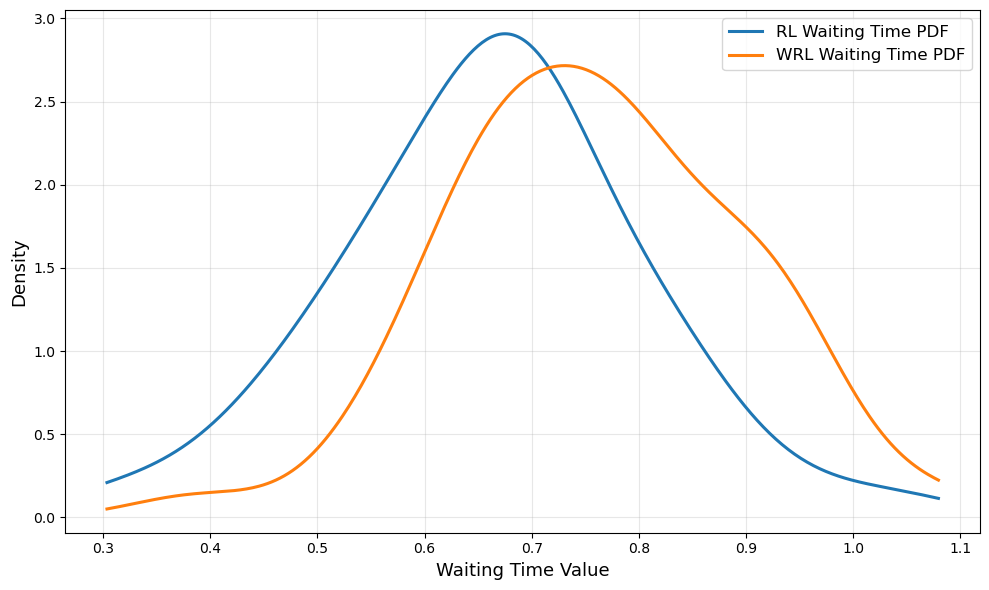

In [71]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

contact_group = 1
d1 = rl_dataset_rl[rl_dataset_rl['Contact Group'] == contact_group]['Waiting Time'].dropna()
d2 = rl_dataset_wrl[rl_dataset_wrl['Contact Group'] == contact_group]['Waiting Time'].dropna()

# KDEs
kde1 = gaussian_kde(d1)
kde2 = gaussian_kde(d2)

# Build a shared x-grid
xmin = min(d1.min(), d2.min())
xmax = max(d1.max(), d2.max())
x = np.linspace(xmin, xmax, 400)

# Plot
plt.figure(figsize=(10,6))

plt.plot(x, kde1(x), linewidth=2.2, label='RL Waiting Time PDF')
plt.plot(x, kde2(x), linewidth=2.2, label='WRL Waiting Time PDF')

# plt.title(f'Smoothed PDF Comparison — Contact Group {contact_group}', fontsize=15)
plt.xlabel('Waiting Time Value', fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('Waiting Time RL.png')
plt.show()


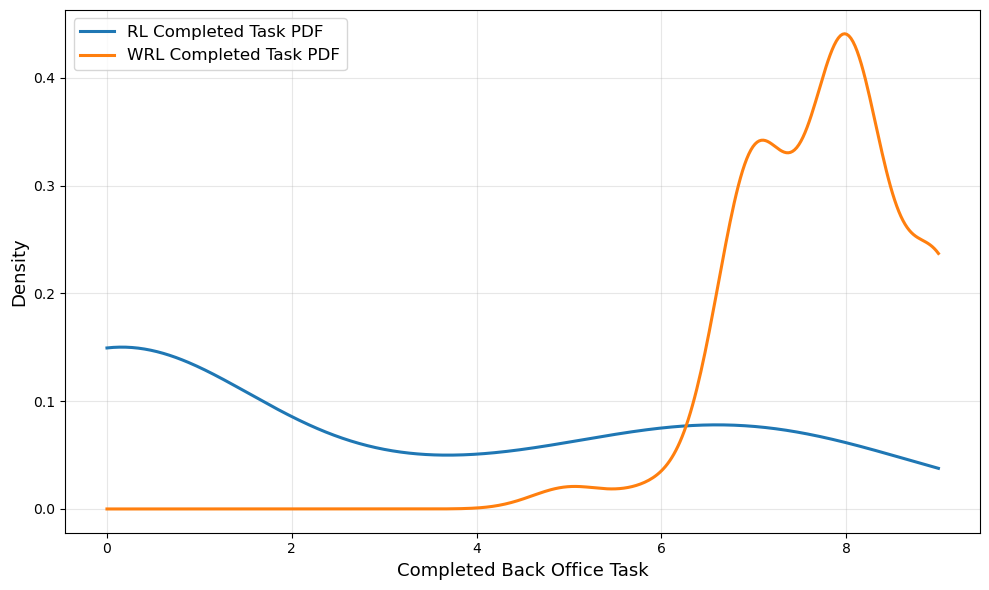

In [72]:
rl_dataset_rl = pd.read_csv(f'data_stat/Completed_Tasks_Stat_Copula_Macro_1_Params_0.7_0.7.csv')
rl_dataset_wrl = pd.read_csv(f'data_stat/Completed_Tasks_Stat_WRL_Copula_Macro_1_Params_0.7_0.7.csv')
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

contact_group = 1
d1 = rl_dataset_rl['Complete Task'].dropna()
d2 = rl_dataset_wrl['Complete Task']

# KDEs
kde1 = gaussian_kde(d1)
kde2 = gaussian_kde(d2)

# Build a shared x-grid
xmin = min(d1.min(), d2.min())
xmax = max(d1.max(), d2.max())
x = np.linspace(xmin, xmax, 400)

# Plot
plt.figure(figsize=(10,6))
plt.plot(x, kde1(x), linewidth=2.2, label='RL Completed Task PDF')
plt.plot(x, kde2(x), linewidth=2.2, label='WRL Completed Task PDF')
# plt.title(f'Smoothed PDF Comparison', fontsize=15)
plt.xlabel('Completed Back Office Task', fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('Complete Task RL.png')
plt.show()